# ICORES 2020

In [1]:
import csv
import json
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()

from lime.lime_text import LimeTextExplainer

from ortools.graph import pywrapgraph

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/nkanak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nkanak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Data has been retrieved from the publicly accessible Jira instance of the open source projects of Apache Foundation.
# Check this URL: https://issues.apache.org/jira .
with open('test.json') as f:
    issues = json.load(f)
issues = issues['issues']

In [3]:
extra_stopwords = ["a", "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", "what's", "when's", "where's", "who's", "why's", "would"]

In [4]:
# Keep only the issues with assignee (HADOOP project).
issues = [issue for issue in issues if issue['fields'].get('assignee') is not None]

In [5]:
len(issues)

42398

In [6]:
from collections import Counter

In [7]:
# TODO: Modify me!
NUMBER_OF_DEVELOPERS_INCLUDED = 4
most_common = Counter([issue['fields']['assignee']['key'] for issue in issues]).most_common(NUMBER_OF_DEVELOPERS_INCLUDED)
most_common

[('rxin', 722), ('szetszwo', 706), ('cloud_fan', 633), ('tlipcon', 561)]

In [8]:
included_developers = [developer_name for developer_name, _ in most_common]

In [9]:
# Keep only the issues of the 4 most important employees, i.e. employees with the highest number of assigned issues (statistical significance).
issues = [issue for issue in issues if issue['fields']['assignee']['key'] in included_developers]

In [10]:
included_developers

['rxin', 'szetszwo', 'cloud_fan', 'tlipcon']

In [11]:
len(issues)

2622

In [12]:
unique_assignees_to_number_mapping = {assignee: key for key, assignee in enumerate(list(set(issue['fields']['assignee']['key'] for issue in issues)))}
unique_person_names = sorted([key for key in unique_assignees_to_number_mapping], key=lambda name: unique_assignees_to_number_mapping[name])
print(unique_assignees_to_number_mapping)

{'tlipcon': 0, 'cloud_fan': 1, 'szetszwo': 2, 'rxin': 3}


In [13]:
columns = {
    'class': [issue['fields']['assignee']['key'] for issue in issues],
    'text': [(issue['fields']['description'] if issue['fields']['description'] is not None else '') + ' ' + issue['fields']['summary'] for issue in issues],
}

In [14]:
# Compose and clean up text.
# The text of each issue is composed of two attrributes, namely description and summary (see above).
# Removal of english stop words is performed as well as lemmatization and stemming.
# Lemmatization (a Text Normalization technique) is the process of grouping together the different inflected forms of a word so they can be analysed as a single item.
# Stemming is the process of reducing inflected (or sometimes derived) words to their base or root form.
# Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma.
# Stemming is different to Lemmatization in the approach it uses to produce root forms of words and the word produced.
# Also lemmatization and stemming techniques decrease the number of features of each row as far as machine learning is concerned.
for i in range(len(columns['text'])):
    columns['text'][i] = ' '.join([stemmer.stem(wordnet_lemmatizer.lemmatize(word.lower(), pos='v')) for word in columns['text'][i].split() if word.lower() not in stopwords.words('english') + extra_stopwords])

In [15]:
issues_df = pd.DataFrame.from_dict(columns)
#issues_df

In [16]:
issues_df['class'].value_counts()

rxin         722
szetszwo     706
cloud_fan    633
tlipcon      561
Name: class, dtype: int64

Text(0, 0.5, 'number of issues')

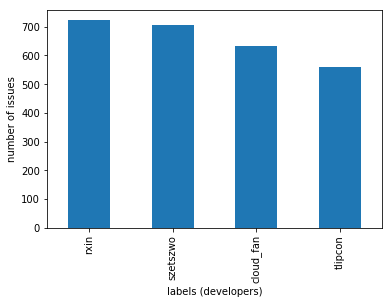

In [17]:
ax = issues_df['class'].value_counts().plot(kind='bar')
ax.set_xlabel('labels (developers)')
ax.set_ylabel('number of issues')

## Example

In [18]:
#issues_df

In [19]:
issues_df['label'] = issues_df['class'].map(unique_assignees_to_number_mapping)

In [20]:
X = issues_df['text']
y = issues_df['label']
# Tokenization, tag/feature generation and removal of frequently occured tags/words.
#cv = CountVectorizer(stop_words='english', max_df=0.6, max_features=200)
#cv = CountVectorizer(stop_words='english', max_df=0.6)

#from sklearn.ensemble import ExtraTreesClassifier

#model = ExtraTreesClassifier(n_estimators=10)
#model.fit(X_transformed, y)
#importances = [(i, importance) for i, importance in enumerate(model.feature_importances_)]
#importances = sorted(importances, reverse=True, key=lambda x: x[1])
#feature_names = cv.get_feature_names()

#X_transformed = cv.fit_transform(X)

cv = CountVectorizer(stop_words='english', max_df=0.6)
X_transformed = cv.fit_transform(X)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_transformed, y, range(0, len(issues_df)), test_size=0.33, random_state=42)
print('Train size %s' % X_train.shape[0])
print('Test size %s' % X_test.shape[0])
print('Number of features %s' % X_test.shape[1])


#for importance in importances:
#    print(feature_names[importance[0]], importance[1])
print(cv.vocabulary)

Train size 1756
Test size 866
Number of features 12496
None


In [21]:
# Naive Bayes classifier for multinomial models.
# The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).
# The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
naive_clf = MultinomialNB()
naive_clf.fit(X_train,y_train)
naive_clf.score(X_test,y_test)

0.7217090069284064

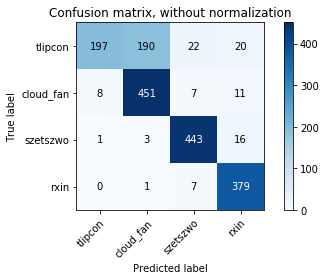

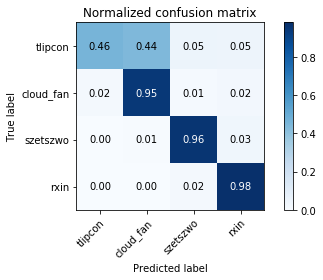

In [22]:
y_predicted = [unique_person_names[i] for i in  naive_clf.predict(X_transformed[indices_train])]
y_true = issues_df.iloc[indices_train]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_predicted, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_predicted, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [23]:
# Text Explainer for explaining the selected examples.
# Reference: https://arxiv.org/abs/1602.04938
# The Explanations help us to check the reliability and validity of the trained machine learning model.
# The Explanations confirm that the model chooses the right label/class for the right reason (e.g. meaningful words/features).
#explainer = LimeTextExplainer(class_names=unique_person_names)

In [24]:
#def explain_classification(text, classifier):
#    return explainer.explain_instance(text, lambda x: classifier.predict_proba(cv.transform(x)), top_labels=4)

In [25]:
#unique_assignees_to_number_mapping

In [26]:
#def analyze_selected_examples(index):
#    print(index)
#    print('Real selected label: %s' % issues_df.iloc[index]['class'])
#    print('Probabilities of each label: %s' % naive_clf.predict_proba(cv.transform([issues_df.iloc[index]['text']])))
#    print('Summary: %s' % issues[index]['fields']['summary'])
#    print('Description: %s' % issues[index]['fields']['description'] if issues[index]['fields']['description'] is not None else '')
#    exp = explain_classification(issues_df.iloc[index]['text'], naive_clf)
#    exp.show_in_notebook()
#    exp.save_to_file('example_explanations/%s.html' % (index))
#    return exp

In [27]:
#analyze_selected_examples(138)

In [28]:
#analyze_selected_examples(65)

In [29]:
#analyze_selected_examples(85)

In [30]:
#analyze_selected_examples(109)

In [31]:
# OR part of the example.
# Target?: To maximize the chance of success of the software company.
# How?: By assigning the employees in such a way that the total relevance is maximized.
# Relevance = skills required by an issue vs skills possessed by an employee.
# In our example the 'relevance' is equivalent to the probability (calculated by our model) an employee is suitable for doing a specific issue.
# OR algorithm?: Linear Assignment Problem (LAP) (https://developers.google.com/optimization/assignment/simple_assignment).

In [32]:
#selected_example_indeces = [138, 65, 85, 109]

In [33]:
# Row == employee.
# Column == issue.
# Transpose a list code: list(map(list, zip(*l)))
#relevance_of_each_employee_per_issue = list(map(list, zip(*[
#    list(naive_clf.predict_proba(cv.transform([issues_df.iloc[i]['text']]))[0]) for i in selected_example_indeces
#])))
#relevance_of_each_employee_per_issue_percentage = [[int(round(c*100)) for c in row] for row in relevance_of_each_employee_per_issue]
#print('Relevance of each employee per issue: %s' % relevance_of_each_employee_per_issue_percentage)

In [34]:
#def assign_employees_to_issues():
#  cost = create_data_array()
#  rows = len(cost)
#  cols = len(cost[0])

#  assignment = pywrapgraph.LinearSumAssignment()
#  for worker in range(rows):
#    for task in range(cols):
#      if cost[worker][task]:
#        assignment.AddArcWithCost(worker, task, cost[worker][task])
#  solve_status = assignment.Solve()
#  if solve_status == assignment.OPTIMAL:
#    total_relevance = 0
#    for i in range(0, assignment.NumNodes()):
#      relevance = relevance_of_each_employee_per_issue_percentage[i][assignment.RightMate(i)]
#      total_relevance += relevance
#      print('Employee %s (index:%s) is assigned to issue %s.  Relevance = %d' % (
#            unique_person_names[i],
#            i,
#            selected_example_indeces[assignment.RightMate(i)],
#            relevance))
#    print()
#    print('Total relevance = ', total_relevance)
#  elif solve_status == assignment.INFEASIBLE:
#    print('No assignment is possible.')
#  elif solve_status == assignment.POSSIBLE_OVERFLOW:
#    print('Some input costs are too large and may cause an integer overflow.')

#def create_data_array():
#  cost = relevance_of_each_employee_per_issue_percentage
#  inverse_cost = [[100 - c for c in row] for row in cost]
#  return inverse_cost

In [35]:
# The Outcome of the example.
# Evaluation http://www.hungarianalgorithm.com/solve.php?c=96-95-8-53--0-4-92-1--4-0-0-3--0-1-0-43&obj=max
#assign_employees_to_issues()

In [36]:
#analyze_selected_examples(51)

In [37]:
# Feature Importance with Extra Trees Classifier
#from pandas import read_csv
#from sklearn.ensemble import ExtraTreesClassifier
# load data
#url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
#names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
#dataframe = read_csv(url, names=names)
#array = dataframe.values
#X = array[:,0:8]
#Y = array[:,8]
# feature extraction
#model = ExtraTreesClassifier(n_estimators=10)
#model.fit(X, Y)
#print(model.feature_importances_)